In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from collections import defaultdict
import os
import json
from matplotlib import pyplot as plt

from src.dataset_handling import TextClassificationDataset
from src.utils import get_activations_and_labels, get_hidden_activations
from src.sparse_autoencoders import SAE_topk

In [3]:
model_url = "EleutherAI/pythia-14m"
model_name = model_url.split('/')[-1]
hookpoint_name = 'gpt_neox.layers.$.mlp.act'
layer = 3

model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_url)

num_hookpoints = model.config.num_hidden_layers
hookpoint = hookpoint_name.replace('$', str(layer))
input_size = model.config.intermediate_size

data_path = 'data/split/tedtalks_test.tsv'
dataset = TextClassificationDataset.from_tsv(data_path)

In [5]:
expansion_factor = 4

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 20
}

sae = SAE_topk(meta_data=meta_data)

sae.load_state_dict(torch.load(f'models/sparse_autoencoders/pythia-14m/{hookpoint}.pt', weights_only=True))

<All keys matched successfully>

In [19]:
da_acts = []
da_preacts = []
en_acts = []
en_preacts = []

for i in range(100):

    sent, label = dataset[i]

    tokenized = [
        tokenizer(input_, return_tensors='pt').to(device)
        for input_ in [sent]
    ]

    transformer_acts = get_hidden_activations(model, hookpoint, tokenized)

    sae_preacts = sae.get_preacts(transformer_acts)
    sae_acts = sae.get_activations(transformer_acts)

    for act_indices, preacts in zip(sae_acts.indices, sae_preacts):

        zeros = torch.zeros(input_size * expansion_factor)

        zeros[act_indices] = 1

        if label == 0:
            da_acts.append(zeros)
            da_preacts.append(preacts)
        else:
            en_acts.append(zeros)
            en_preacts.append(preacts)

In [14]:
avg_da = sum(da_acts) / len(da_acts)
avg_en = sum(en_acts) / len(en_acts)

In [34]:
max_diff_neuron = torch.argmax(avg_da - avg_en)

In [44]:
da_preacts_tnsr = torch.stack(da_preacts).detach()
en_preacts_tnsr = torch.stack(en_preacts).detach()

In [43]:
def plot_difference_by_neuron(da_preacts, en_preacts, neuron):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_title(f'Neuron {neuron}')
    ax.hist(da_preacts[:, neuron], bins=30, alpha=0.5, color='blue')
    ax.hist(en_preacts[:, neuron], bins=30, alpha=0.5, color='orange')

    fig.tight_layout()
    fig.show()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_3708\2055940904.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


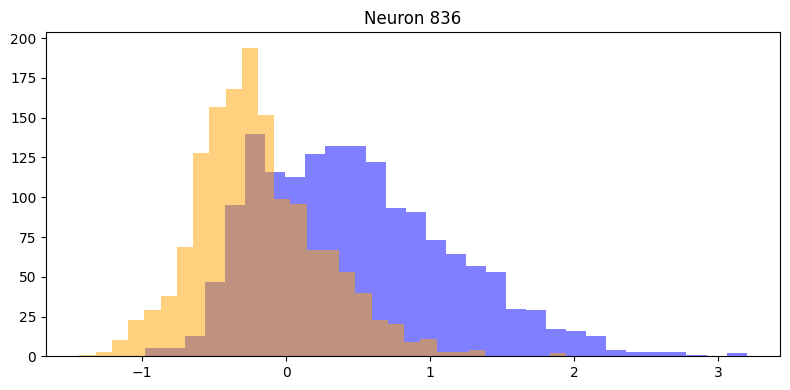

In [49]:
plot_difference_by_neuron(da_preacts_tnsr, en_preacts_tnsr, max_diff_neuron)